In [4]:
# calculate the slope of the daily data: cooling vs. change in temp per day
# slope is the e folding parameter in pierce equations (gamma)
# focus in the areas of cooling >= 1.5 (2) degrees

In [114]:
import sys
import os
os.environ['PROJ_LIB']='/anaconda3/share/proj'
sys.path.append('/Users/sol/Google Drive/professional/research/utilities/python_myfun')
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

In [115]:
def smooth_cw_area(cw_mask):
    nmask = cw_mask.copy()
    ny, nx = len(cw_mask.lat), len(cw_mask.lon)
    for i in range(ny):
        for j in range(nx):
            if ~np.isnan(nmask[i,j]):
                # check for 3 points withing ~100km
                box = nmask[i-2:i+2,j-2:j+2]
                tbox = np.nansum(box)
                if tbox<4:
                    nmask[i,j] = np.nan
    return nmask

In [179]:
# get all data ready
dirfiles='/Users/sol/Documents/LargeData/tc_wakes/storms_Data/'
gam=list()
rsq=list()
pv=list()
sid=list()
ster=list()
yr=list()
sst0=list()
wfor=list()
for root, dirs, files in os.walk(dirfiles, topdown=False):
    l=len(root)
    if l>len(dirfiles):
        # storm to analyze
        strm_id = root[l-7:l]
        stn=strm_id[4:7]
        dir_in=dirfiles+strm_id+'/'

        fin=dir_in+stn+'_coldwake_maskanddata.nc'
        cw=xr.open_dataset(fin)
        cw.close()

        #storm, storm_date = get_stormtrackdata(strm_id)

        fn=dir_in+stn+'_combined_data.nc'
        dt=xr.open_dataset(fn)
        dt.close()

        # calculate mask of 1.5 degrees
        cw2_mask = cw.Max_Cooling.where(cw.Max_Cooling<=-1.5)
        cw2_mask = cw2_mask*0+1
        cw2_mask = smooth_cw_area(cw2_mask)

        # calculate gamma
        gamma, r2, p_value, std_err, sst_0, wf = calculate_gamma()

        # save values
        sid.append(strm_id)
        yr.append(int(strm_id[0:4]))
        gam.append(-gamma)
        rsq.append(r2)
        pv.append(p_value)
        ster.append(std_err)
        sst0.append(sst_0)
        wfor.append(wf)
        
        
d = {'Storm ID':sid, 'Year':yr, 'Gamma':gam, 'r2': rsq, 'p-value':pv, 'Std error': ster, 'SST0':sst0, 'wind forcing':wfor}
dtx = pd.DataFrame(data=d)
dir_out = dirfiles+'gamma_values_allstorms.csv'
dtx.to_csv(dir_out)

Storm:  2013055
Coefficients:  -3.3941257987417557 -0.6766979199003735
r-squared:  0.18908473452946803 , p-value:  1.692583327546375e-43
Storm: 2013038 Not enough points
Storm:  2007039
Coefficients:  -1.492029347200956 -1.030487044909158
r-squared:  0.4265133598762287 , p-value:  6.910006553444305e-18
Storm:  2014072
Coefficients:  -5.868409071336847 -0.3497260738331244
r-squared:  0.05884072318167058 , p-value:  0.004743428168525684
Storm:  2014086
Coefficients:  -2.911375414042214 -0.5812483538884141
r-squared:  0.2869158463593916 , p-value:  3.1892172519072254e-19
Storm:  2005088
Coefficients:  -3.7856410873914315 -0.6966551592675658
r-squared:  0.26437442986430254 , p-value:  3.3712607675515773e-76
Storm:  2006055
Coefficients:  -1.1435173246773895 -1.283583234575855
r-squared:  0.6095028924671105 , p-value:  1.4846118954892103e-44
Storm:  2005086
Coefficients:  -1.8395715567622861 -0.9282260540536175
r-squared:  0.5255614872731184 , p-value:  1.2819295685649188e-38
Storm:  200605

In [178]:
def calculate_gamma():
    # for all points in the new mask for all days of the coldwake, make a list of: 
    # SST cooling (sst-sst0) and d sst/ dt (change towards next day)
    # use that list to plot, calculate the slope
    nx,ny = len(cw.lon), len(cw.lat)
    sst_cool=list()
    dsst_dt=list()
    sst0_all=list()
    dist=list()
    wf_all=list()
    for ilat in range(ny):
        for ilon in range(nx):
            if ~np.isnan(cw2_mask[ilat,ilon]):
                cwi=int(cw.Coldwake_begin_day[ilat,ilon].values)
                if  cwi>=7:
                    # for each coldwake point, for each day of the cw
                    sst0=cw.preSST[ilat,ilon].values
                    cwf=int(cw.Coldwake_end_day[ilat,ilon].values)
                    for i in range(cwi,cwf+1):
                        sst_cool.append(dt.analysed_sst[i,ilat,ilon].values-sst0)
                        sst0_all.append(sst0)
                        dist.append(dt.dist_from_storm_km[ilat,ilon].values)
                        wf_all.append(cw.wind_forcing[ilat,ilon].values)
                        if i<len(dt.lat)-1:
                            dsst_dt.append(dt.analysed_sst[i+1,ilat, ilon].values-dt.analysed_sst[i,ilat, ilon].values)
                        else:
                            dsst_dt.append(dt.analysed_sst[i,ilat, ilon].values-dt.analysed_sst[i-1,ilat, ilon].values)
    if len(sst_cool)>50:
        # calculate linear fit
        gamma_inv, interc, r_value, p_value, std_err = stats.linregress(sst_cool, dsst_dt)
        sst0_str=np.nanmean(sst0_all)
        windf=np.nanmean(wf_all)

        # The coefficients
        print('Storm: ', strm_id)
        print('Coefficients: ', 1/gamma_inv, interc)
        # The mean squared error
        print('r-squared: ',r_value**2,', p-value: ', p_value )
    else:
        print('Storm:', strm_id, 'Not enough points')
        gamma_inv, r_value, p_value, std_err, sst0_str, windf = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    return 1/gamma_inv, r_value**2, p_value, std_err, sst0_str, windf


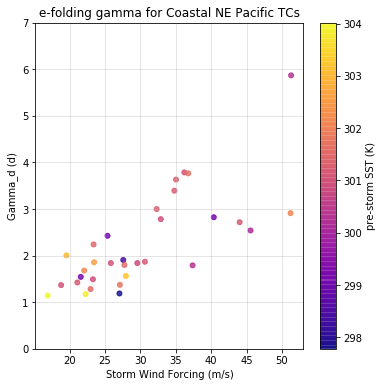

In [187]:
cm=plt.cm.get_cmap('plasma')
plt.figure(figsize=(6,6))
plt.scatter(wfor,gam,c=sst0, s=25,alpha=0.8,cmap=cm)
plt.plot(x_pred,y_pred,color='k',linewidth=3)
cb=plt.colorbar()
cb.set_label('pre-storm SST (K)')
plt.xlabel('Storm Wind Forcing (m/s)')
plt.ylabel('Gamma_d (d)')
plt.ylim(0,7)
plt.title('e-folding gamma for Coastal NE Pacific TCs')
plt.grid(True,alpha=0.4)
plt.show()

In [ ]:
ñn

In [ ]:
cm=plt.cm.get_cmap('plasma')
plt.figure(figsize=(6,6))
plt.scatter(SST0,gamma,c=yr, s=15,alpha=0.8,cmap=cm)
plt.plot(x_pred,y_pred,color='k',linewidth=3)
cb=plt.colorbar()
cb.set_label('Distance to storm (km)')
plt.xlabel('SST cooling (C)')
plt.ylabel('dSST/dt (C/day)')
plt.title(strm_id+', '+'e-folding gamma')
plt.grid(True,alpha=0.4)
plt.show()

In [167]:
len(yr)

48

In [145]:
x_pred=np.arange(min(sst_cool),max(sst_cool)+0.1, 0.01)
y_pred=interc+gamma*x_pred

In [17]:
cw

<xarray.Dataset>
Dimensions:            (lat: 128, lon: 128)
Coordinates:
  * lat                (lat) float64 6.875 7.127 7.379 ... 38.37 38.62 38.88
  * lon                (lon) float64 -128.4 -128.1 -127.9 ... -96.63 -96.38
    time               datetime64[ns] ...
Data variables:
    coldwake_mask      (lat, lon) float64 ...
    wind_forcing       (lat, lon) float64 ...
    storm_arrival_day  (lat, lon) float64 ...
    preSST             (lat, lon) float64 ...
    Max_Cooling        (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Max_Cooling_day    (lat, lon) float64 ...

In [147]:
dt

,Storm ID,Gamma,r2,p-value,Std error
0,2013055,-3.394126,0.189085,1.692583e-43,0.020193
1,2013038,NaN,NaN,NaN,NaN
2,2007039,-1.492029,0.426513,6.910007e-18,0.067138
3,2014072,-5.868409,0.058841,4.743428e-03,0.059318
4,2014086,-2.911375,0.286916,3.189217e-19,0.035100
5,2005088,-3.785641,0.264374,3.371261e-76,0.013214
6,2006055,-1.143517,0.609503,1.484612e-44,0.048418
7,2005086,-1.839572,0.525561,1.281930e-38,0.034281
8,2006052,-1.424036,0.460409,2.202763e-114,0.026261
9,2012053,-1.906001,0.332295,3.944452e-77,0.025420
